In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 123
np.random.seed(SEED)

In [2]:
## helper fns
def get_error_term(v1, v2, _rmse=True):
    '''
    get mean absolute error term if _rmse is False, else, 
    get rmse
    args:
    - predictions
    - ground truth
    return:
    - mae or rmse
    '''
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

# The reparameterization trick
def sample(args):
    '''
    sample the normally distributed z
    args:
    - args containing z_mean, z_log_var
    return:
    - sampled vector z (mean + sigma * epsilon)
    '''
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# the KL loss function:
def vae_loss(x, x_decoded_mean):
    '''
    compute the average MSE error, then scale it up, ie. simply sum on all axes
    args:
    - input
    - decoded input mean
    return:
    - total reconstruction loss
    '''
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    return total_loss

In [3]:
# read the data with engineered features
df = pd.read_csv('../data/processed/df_w_feat_eng.csv')

In [4]:
dr_and_amt_features = [col for col in df.columns if 'timestamp' not in col and 'clss' not in col]
len(dr_and_amt_features)

58

## Model preparation

### Normalize inputs

Normalize the inputs so that the optimizer (Adam) converges faster

In [5]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[dr_and_amt_features])
labels = np.where(df['clss'] == 1, 1, 0)
norm_samples = df_scaled[labels == 0]  # normal data
fraud_samples = df_scaled[labels == 1]  # fraud data

norm_labels = labels[labels == 0]
fraud_labels = labels[labels == 1]

<img src='../img/vae.png' width= "600">

- The underlying idea of using VAE to detect fraudulent cases is based on the assumption that if a model can learn a function that compresses and reconstructs normal data, then it will fail to do so when encountered with anomalous data because its function was only trained on normal data. The failure to reconstruct data or, more accurately, the range of the reconstruction error that it entails, can therefore signal the presence of anomalous data. 
- Hence, the input to the encoder is normal (i.e. non-fraud) data. Since the model is trained on normal data, we can increase our confidence that a relatively high reconstruction error was caused by a fraudulent case

### Generate train and test set

In [6]:
# generate train set
# training set will consist of the normal dataset

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]
X_train = X_train[:int(0.8 * len(X_train))]

# generate test set consist of 20% fraud and 20% normal

X_test_norm = norm_samples[len_norm_train:]
len_fraud_test = len(X_test_norm) 
X_test_fraud = fraud_samples[:len_fraud_test]

X_test = np.concatenate([X_test_norm, X_test_fraud])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0
print(X_train.shape, X_test.shape)
print(y_test.shape)

(181942, 58) (57350, 58)
(57350,)


### Set up VAE architecture

In [7]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [8]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 58)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 29)           1711        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 19)           570         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 19)           570         ['dense[0][0]']                  
                                                                                            

In [9]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 19)]              0         
                                                                 
 dense_1 (Dense)             (None, 29)                580       
                                                                 
 dense_2 (Dense)             (None, 58)                1740      
                                                                 
Total params: 2,320
Trainable params: 2,320
Non-trainable params: 0
_________________________________________________________________


In [10]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

## Modeling

### Training

In [11]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=100,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 58)]              0         
                                                                 
 encoder (Functional)        (None, 19)                2851      
                                                                 
 decoder (Functional)        (None, 58)                2320      
                                                                 
Total params: 5,171
Trainable params: 5,171
Non-trainable params: 0
_________________________________________________________________
Train on 181942 samples
Epoch 1/100
Metal device set to: Apple M1


2022-01-26 22:04:51.872299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-26 22:04:51.872410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-26 22:04:51.883061: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-26 22:04:51.883181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 22:04:51.901122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 22:04:51.951372: I tensorflow/core/grappler/o

181942/181942 [==============================] - 4s 23us/sample - loss: 392.7445
Epoch 2/100
181942/181942 [==============================] - 4s 21us/sample - loss: 68.9058
Epoch 3/100
181942/181942 [==============================] - 4s 22us/sample - loss: 56.4989
Epoch 4/100
181942/181942 [==============================] - 4s 21us/sample - loss: 45.8157
Epoch 5/100
181942/181942 [==============================] - 4s 21us/sample - loss: 39.9709
Epoch 6/100
181942/181942 [==============================] - 4s 21us/sample - loss: 36.7881
Epoch 7/100
181942/181942 [==============================] - 4s 21us/sample - loss: 35.0418
Epoch 8/100
181942/181942 [==============================] - 4s 20us/sample - loss: 33.8771
Epoch 9/100
181942/181942 [==============================] - 4s 20us/sample - loss: 32.8302
Epoch 10/100
181942/181942 [==============================] - 4s 21us/sample - loss: 31.7909
Epoch 11/100
181942/181942 [==============================] - 4s 20us/sample - loss: 30.87

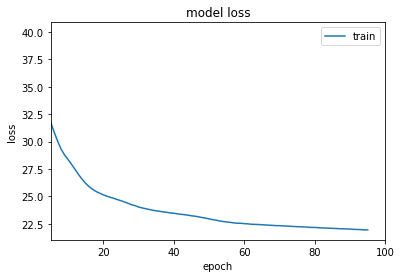

In [12]:
plt.plot(results.history['loss'][4:]) # plot the loss curve from 5th epoch onwards as the 
                                      # high training loss at the start is hiding the slow decrease
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(5, 100)
plt.legend(['train'], loc='upper right');
plt.show()

### Evaluation

In [13]:
X_train_pred = vae_model.predict(X_train)

2022-01-26 22:15:04.588877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1. Measure error between the original train (clean/normal) set and the output of the model, and generate an error vector representing the error term of each sample.

2. Find a relatively extreme value on that vector to use as your error threshold. The assumption is that some anomalies probably introduced some noise into the training set so I picked the 99th percentile as a threshold

3. Run the `vae_model` over the test data, in which fraud data are mixed with normal data.

4. Measure the reconstruction error and mark samples that exhibit an error term higher than the error threshold as fraudulent

In [14]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.023461284709595992
median error 0.02240555745877978
99Q: 0.04341260341106708
setting threshold on 0.04341260341106708 


In [15]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
y_test_pred = (mae_vector > error_thresh)

np.count_nonzero(y_test_pred) / len(y_test_pred)

0.012903225806451613

In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     56858
         1.0       0.42      0.64      0.51       492

    accuracy                           0.99     57350
   macro avg       0.71      0.81      0.75     57350
weighted avg       0.99      0.99      0.99     57350



The VAE model is able to get about 0.42 precision, 0.64 recall and 0.51 f1. This is a significant improvement from the LGBM model with oversampling (0.15, 0.39, 0.22 respectively).

Let's try different percentile to determine error threshold and see if we can improve the above performance.

### Tune error threshold

In [17]:
# generate a list of percentiles from 0.95 to 0.999
err_threshold_list = np.linspace(0.95, 0.999, 10)
f1_score_list = []
recall_score_list = []
precision_score_list = []

for error in err_threshold_list:
    y_test_pred = (mae_vector > np.quantile(mae_vector, error))
    f1_score_list.append(f1_score(y_test, y_test_pred))
    recall_score_list.append(recall_score(y_test, y_test_pred))
    precision_score_list.append(precision_score(y_test, y_test_pred))

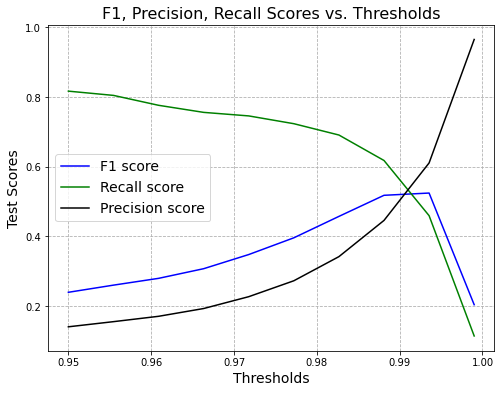

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(err_threshold_list, f1_score_list, color="b", label="F1 score")
ax.plot(err_threshold_list, recall_score_list, color="g", label="Recall score")
ax.plot(err_threshold_list, precision_score_list, color="k", label="Precision score")
ax.set_title('F1, Precision, Recall Scores vs. Thresholds', fontsize=16)
ax.set_xlabel('Thresholds', fontsize=14)
ax.set_ylabel('Test Scores', fontsize=14)
ax.grid(True, linestyle='--')
ax.legend(fontsize=14);

In [19]:
err_threshold_list

array([0.95      , 0.95544444, 0.96088889, 0.96633333, 0.97177778,
       0.97722222, 0.98266667, 0.98811111, 0.99355556, 0.999     ])

Recall is a more importance metric to prioritise than precision for a fraud detection use case. We'd rather flag more transactions for next level review than to miss some of the fraudulent transactions.
Thus, let's take 0.988 as the percentile threshold. 

In [20]:
percentile = 0.988
final_error_thresh = np.quantile(mae_vector, percentile)
y_test_pred_final = (mae_vector > final_error_thresh)
print(classification_report(y_test, y_test_pred_final))


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     56858
         1.0       0.44      0.62      0.51       492

    accuracy                           0.99     57350
   macro avg       0.72      0.81      0.75     57350
weighted avg       0.99      0.99      0.99     57350



This tuned VAE model has a precision score of 0.44. This means, out of 10 frauds identified by the model, about 4 of them truly fraudulent. It has a recall score of of around 0.62 tells us that, out of 10 truly fraudulent cases, the model identified around 6 of them.

Having the cost of identifying false negatives and false positives allows us to set this threshold accordingly. If the cost of identifying false negatives is high, I'll choose a lower percentile threshold. 

In [21]:
X_encoded = encoder.predict(X_test)

2022-01-26 22:15:16.348918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### Visualize results

In [22]:
pca = PCA(n_components=2, random_state=SEED)
X_transform = pca.fit_transform(X_encoded)

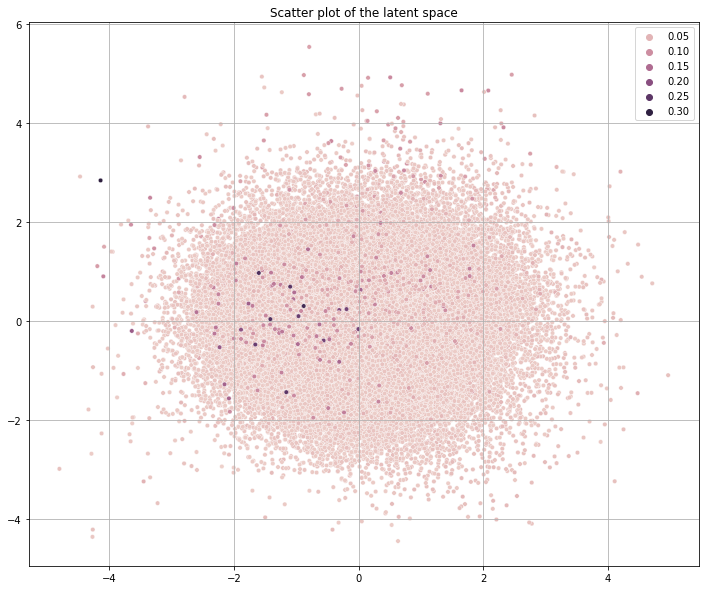

In [23]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.title('Scatter plot of the latent space')
plt.grid()
plt.show()

The plot above shows a scatter plot of the latent space generated by the encoder (after dim reduction to 2 dims). The color of each point reflects its associated reconstruction error term (in the `mae_vector`). A darker dot implies a larger error term. We can clearly see one large cluster of points in the centre (with a relatively small error term), with speckles of points with with a relatively high error term.

We can confirm this with the plot below which plots the same points above after marking each point that has crossed the error threshold as fraudulent (in orange)

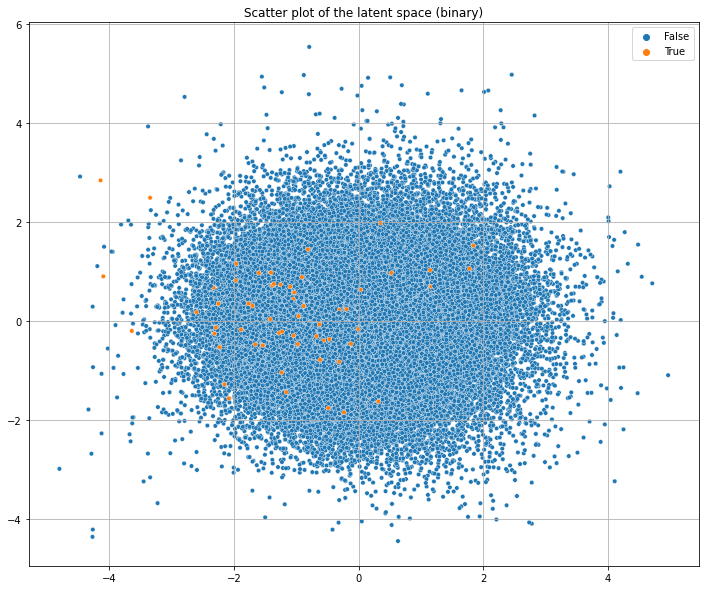

In [24]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=y_test_pred)
plt.title('Scatter plot of the latent space (binary)')
plt.grid()
plt.show();

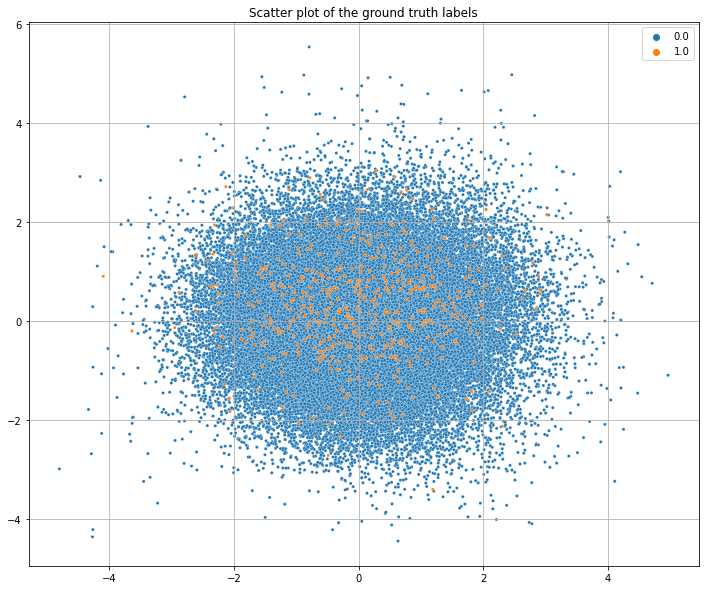

In [25]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.title('Scatter plot of the ground truth labels')
plt.grid()
plt.show();

Finally, we can compare the above predictions to the ground-truth plot below which actually shows the true labels of the data. That is the points colored in orange in this plot are fraudulent. We can see that while we correctly identified some of the frauds (30% of them) in the centre, still there is a small group (around the periphery of the central blob) which we failed to identify, as the plot shows, probably because of some similarity to the normal points. 

In [26]:
vae_model.save('../models/vae_model')

2022-01-26 22:15:20.809890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-26 22:15:20.809910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-26 22:15:21.024206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 22:15:21.026850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 22:15:21.029503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 22:15:21.03

INFO:tensorflow:Assets written to: ../models/vae_model/assets


2022-01-26 22:15:21.298109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Since the VAE model has a higher precision (0.44 vs. 0.13), higher recall (0.66 vs. 0.31) and higher F1 (0.51 vs. 0.18) than LGBM with ovesampling, the chosen model is the VAE model. 

## Next steps

- Find more data source, especially **alternative data**. The bank has many touchpoints with the customers such as mobile app micro behaviours, social media, loan sign up behaviours, relationship with the bank (e.g. how many products this customer bought, campaign history, balance, banking activities etc). 
- Perform more hyperparameter tuning (e.g. width of the model, learning rate etc)